In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv


In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type by https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

In [4]:
basePath = '/kaggle/input/ashrae-energy-prediction/'
building_metadata = pd.read_csv(basePath+'building_metadata.csv')
weather_train = pd.read_csv(basePath+'weather_train.csv')
raw_train = pd.read_csv(basePath+'train.csv')
print(building_metadata.head(10))
print(weather_train.head(10))
print(raw_train.head(10))

   site_id  building_id          primary_use  square_feet  year_built  \
0        0            0            Education         7432      2008.0   
1        0            1            Education         2720      2004.0   
2        0            2            Education         5376      1991.0   
3        0            3            Education        23685      2002.0   
4        0            4            Education       116607      1975.0   
5        0            5            Education         8000      2000.0   
6        0            6  Lodging/residential        27926      1981.0   
7        0            7            Education       121074      1989.0   
8        0            8            Education        60809      2003.0   
9        0            9               Office        27000      2010.0   

   floor_count  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
6          NaN  
7          NaN  
8          NaN  
9          NaN  
   site_i

In [5]:
print('The shape of plain train data is:',np.shape(raw_train))

The shape of plain train data is: (20216100, 4)


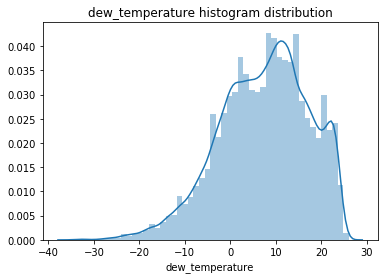

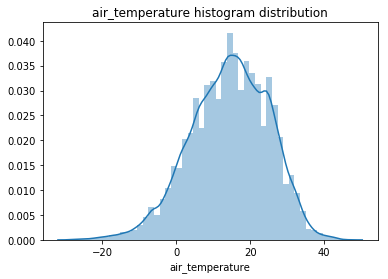

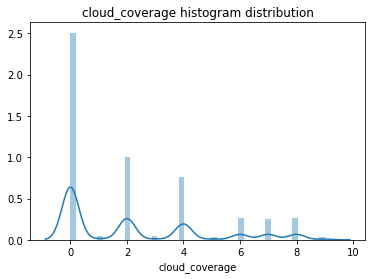

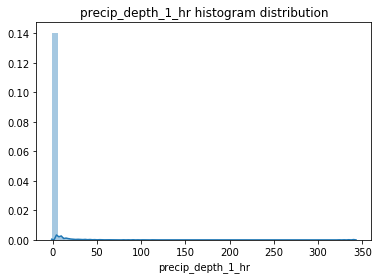

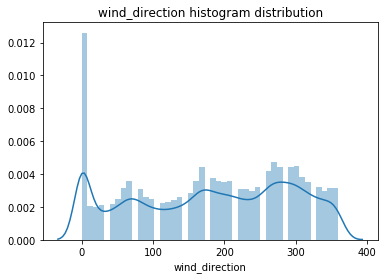

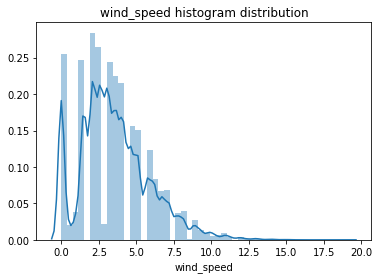

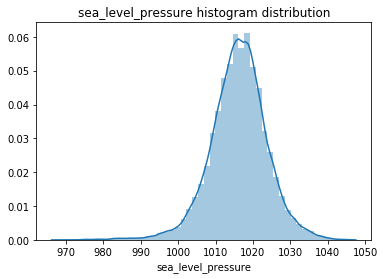

In [6]:
weather_distribution_cols = ['dew_temperature','air_temperature','cloud_coverage','precip_depth_1_hr','wind_direction','wind_speed','sea_level_pressure']
for i,i_col in enumerate(weather_distribution_cols):
    plt.figure(i)
    ax = sns.distplot(weather_train[i_col].dropna())
    ax.set_title(i_col + ' histogram distribution')

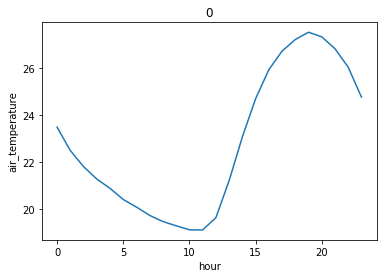

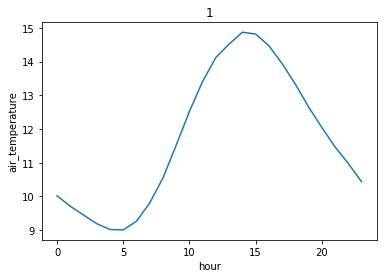

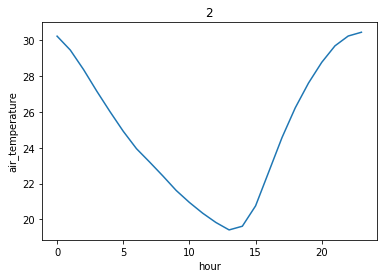

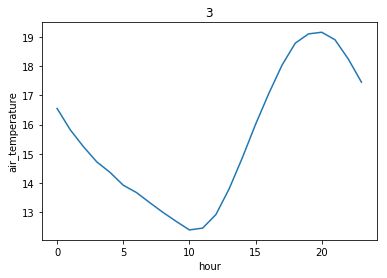

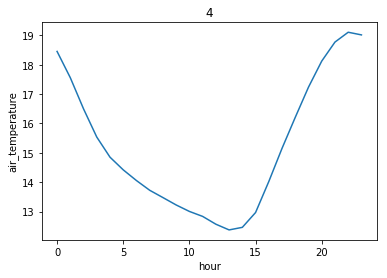

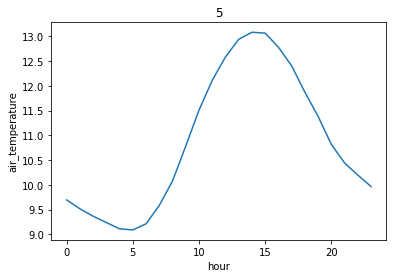

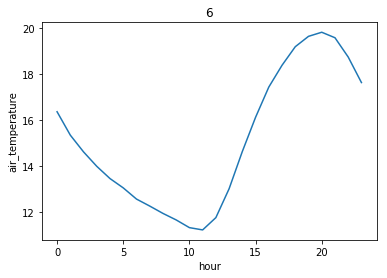

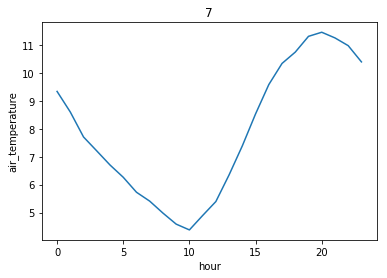

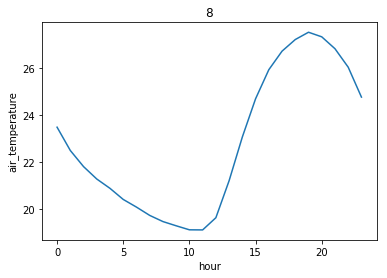

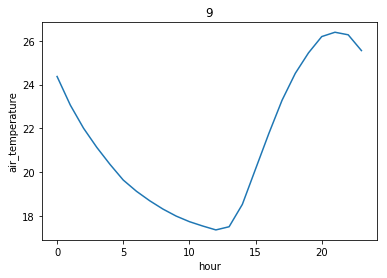

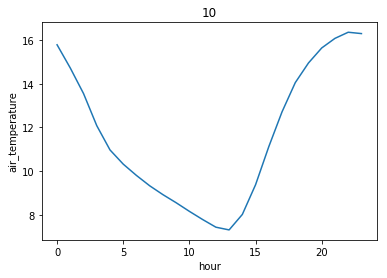

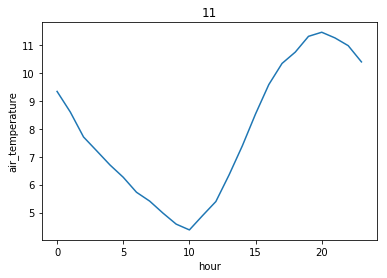

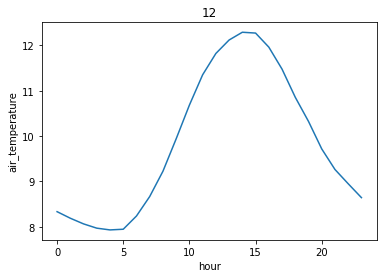

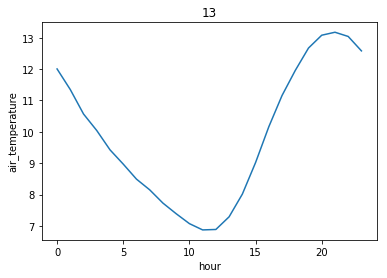

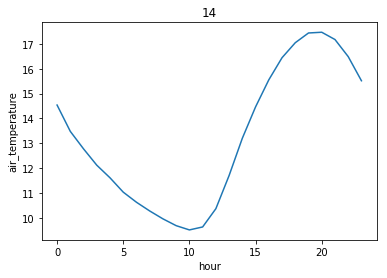

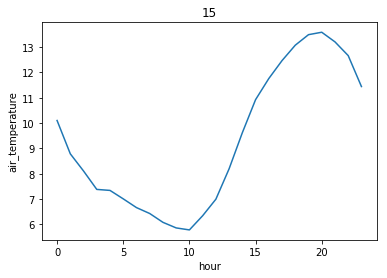

In [7]:
weather_train['hour'] = pd.to_datetime(weather_train['timestamp']).dt.hour
uniqueSites = np.unique(weather_train['site_id'])
for i,i_site in enumerate(uniqueSites):
    plt.figure(i)
    curSiteData = weather_train.loc[weather_train['site_id']==i_site,['hour','air_temperature']].groupby('hour').mean().reset_index()
    ax = sns.lineplot(x="hour", y="air_temperature", data=curSiteData)
    ax.set_title(i_site)  

As noted in many of the other kernels, the timestamps seem to be not aligned in weather_train as in some occassions we notice peak temperature late in the night. If we assume 2 pm to be the peak temperature and update the timestamps it might be good!

In [8]:
del curSiteData
gc.collect()

67919

In [9]:
weather_train = weather_train.drop('hour',axis=1)

In [10]:
offsetBase = weather_train[['site_id','timestamp','air_temperature']]
offsetBase['timestamp'] = pd.to_datetime(offsetBase['timestamp'])
offsetBase['temp_rank'] = offsetBase.groupby(['site_id', offsetBase.timestamp.dt.date])['air_temperature'].rank('average')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
offsetBase_2d = offsetBase.groupby(['site_id',offsetBase.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)
site_offset = pd.Series(offsetBase_2d.values.argmax(axis=1))-14
site_offset.index.name = 'site_id'

In [12]:
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
def alignTimestamp(df):
    df['offset'] = df.site_id.map(site_offset)
    df['timestamp_updated'] = df['timestamp'] - pd.to_timedelta(df['offset'],unit='H')
    df['timestamp'] = df['timestamp_updated']
    df = df.drop('timestamp_updated',axis=1)
    return df

weather_train = alignTimestamp(weather_train)

In [13]:
weather_na_cols = ["wind_direction","wind_speed"]
for i,i_col in enumerate(weather_na_cols):
    weather_train[i_col].fillna(weather_train[i_col].mean(),inplace=True)

In [14]:
raw_train['timestamp'] = pd.to_datetime(raw_train['timestamp'])
raw_train['dayofweek'] = raw_train['timestamp'].dt.dayofweek
raw_train['weekday'] = raw_train['timestamp'].dt.weekday
raw_train['hour'] = raw_train['timestamp'].dt.hour
raw_train['day'] = raw_train['timestamp'].dt.day
raw_train['month'] = raw_train['timestamp'].dt.month

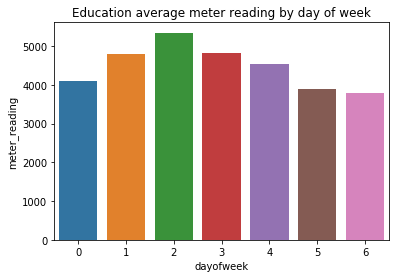

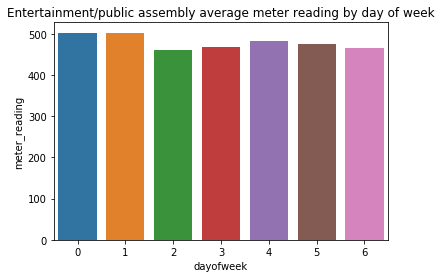

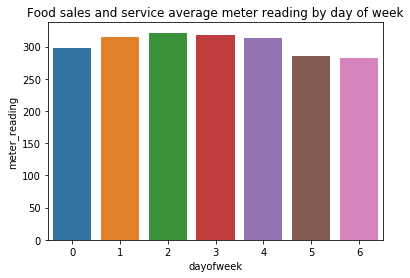

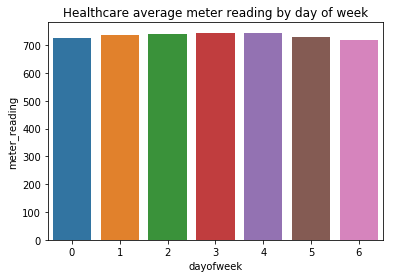

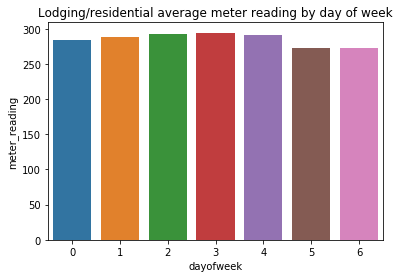

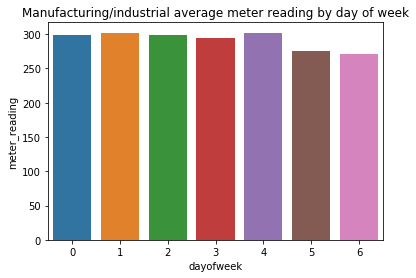

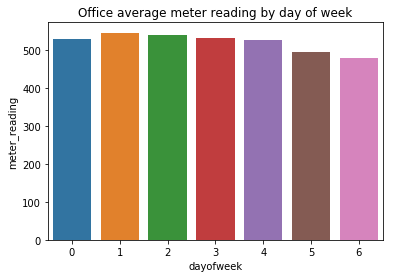

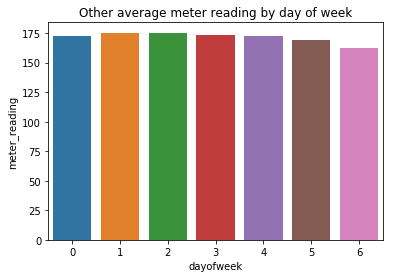

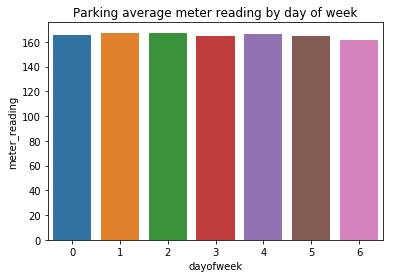

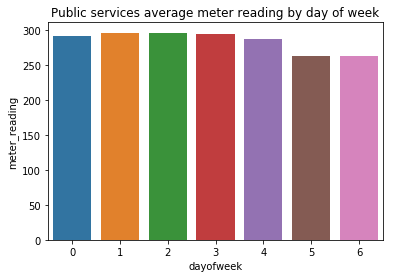

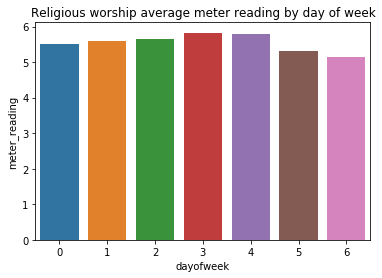

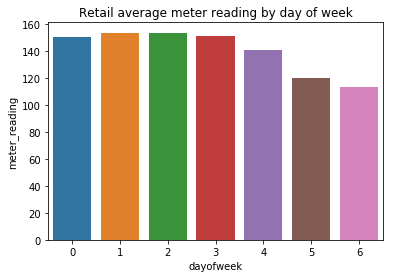

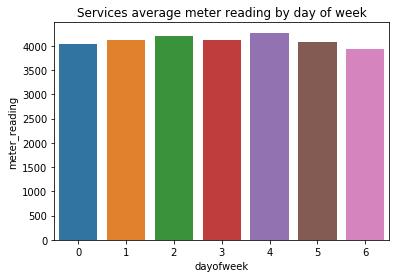

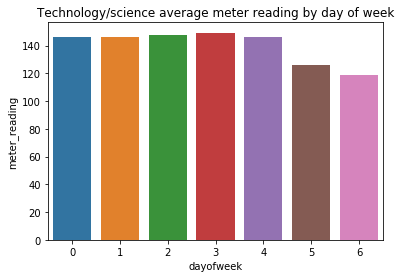

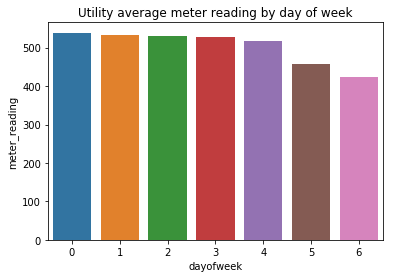

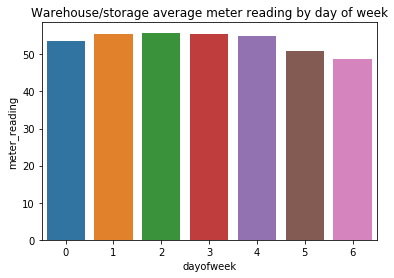

In [15]:
groupedDOWTrainData = raw_train.groupby(['building_id','dayofweek','meter']).mean().reset_index()
groupedDOWTrainData_buildingInfo = pd.merge(groupedDOWTrainData, building_metadata, on='building_id', how='left')
primary_use = np.unique(groupedDOWTrainData_buildingInfo.primary_use)
for i,i_use in enumerate(primary_use):
    plt.figure(i)
    ax = sns.barplot(x="dayofweek", y="meter_reading", data=groupedDOWTrainData_buildingInfo.loc[groupedDOWTrainData_buildingInfo['primary_use']==i_use].groupby('dayofweek').mean().reset_index()[['dayofweek','meter_reading']])
    ax.set_title(str(i_use) + ' average meter reading by day of week')  


del groupedDOWTrainData    

Key thing to be noted is while for most of the building sites the average meter reading drops for Saturday and Sunday, it largely remains flat or inverts this trend for entertainment (it even dips here on weekdays), healthcare, parking...so day of week is likely to play a key role (which also makes sense intuitively) in the meter reading

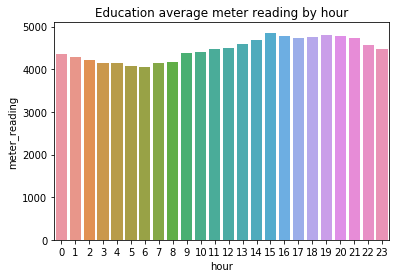

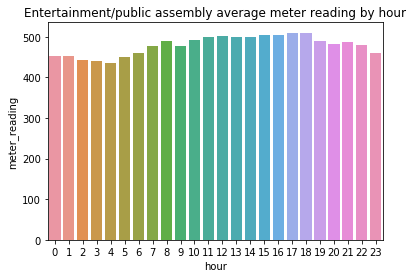

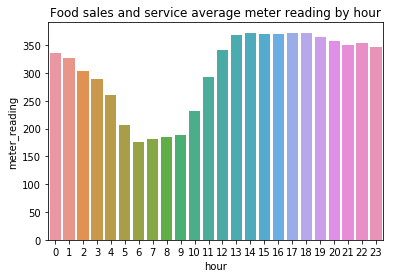

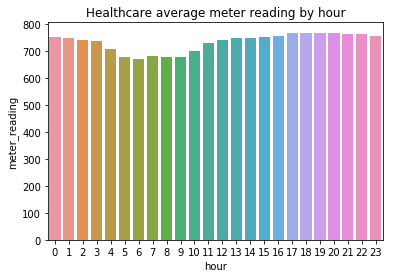

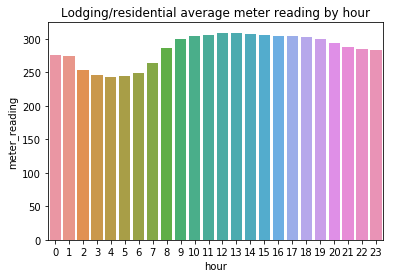

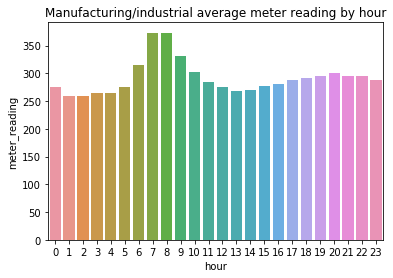

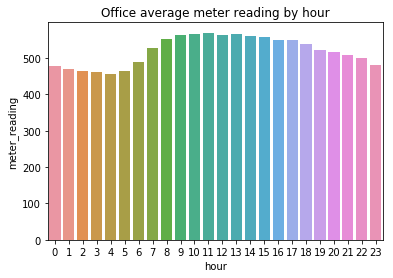

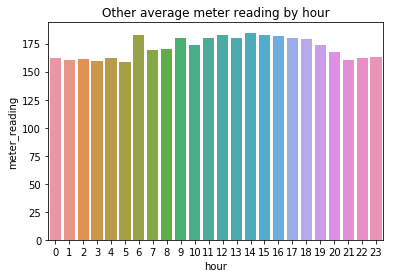

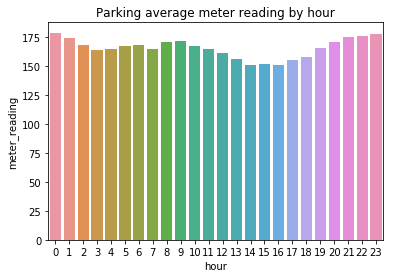

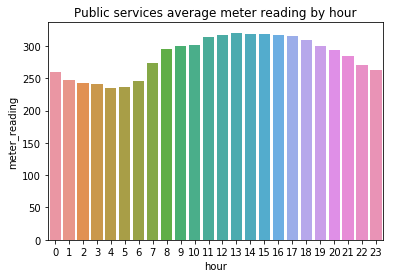

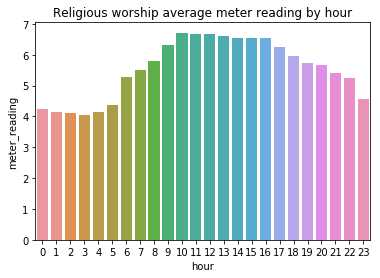

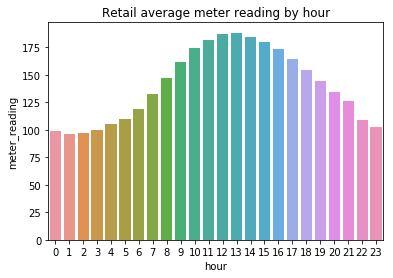

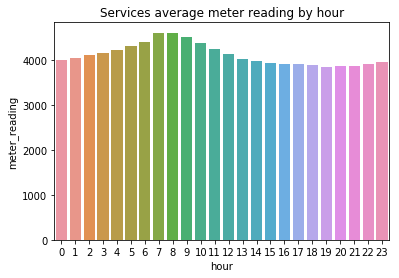

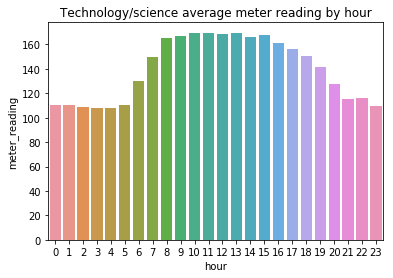

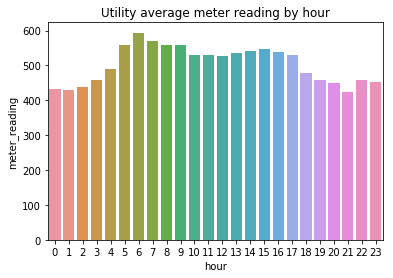

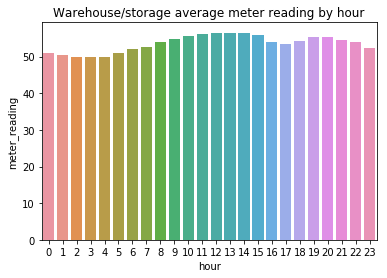

In [16]:
groupedHourTrainData = raw_train.groupby(['building_id','hour','meter']).mean().reset_index()
groupedHourTrainData_buildingInfo = pd.merge(groupedHourTrainData, building_metadata, on='building_id', how='left')
for i,i_use in enumerate(primary_use):
    plt.figure(i)
    ax = sns.barplot(x="hour", y="meter_reading", data=groupedHourTrainData_buildingInfo.loc[groupedHourTrainData_buildingInfo['primary_use']==i_use].groupby('hour').mean().reset_index()[['hour','meter_reading']])
    ax.set_title(str(i_use) + ' average meter reading by hour')  
    
del groupedHourTrainData

Once again there are clear trends in energy usage - it is mostly low between hours 0-6 and starts peaking up slowly and remains high till around hour 21.

In [17]:
del raw_train
gc.collect()

86851

In [18]:
raw_train = pd.read_csv(basePath+'train.csv')

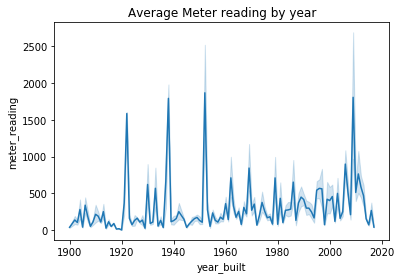

In [19]:
raw_train_building_info = pd.merge(raw_train, building_metadata,left_on = "building_id", right_on = "building_id", how = "left")
groupedYearBuiltTrainData = raw_train_building_info.groupby(['year_built']).mean().reset_index()
ax = sns.lineplot(x="year_built", y="meter_reading", data=groupedDOWTrainData_buildingInfo[['year_built','meter_reading']])
ax.set_title('Average Meter reading by year')  
del groupedYearBuiltTrainData  

Text(0.5, 1.0, 'Average Meter reading by floor count')

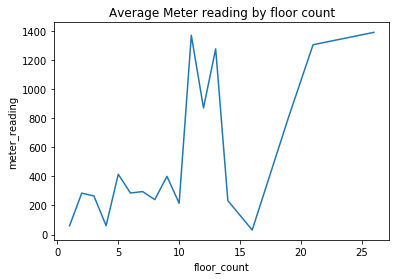

In [20]:
groupedFloorCountTrainData = raw_train_building_info.groupby(['floor_count']).mean().reset_index()
ax = sns.lineplot(x="floor_count", y="meter_reading", data=groupedFloorCountTrainData[['floor_count','meter_reading']])
ax.set_title('Average Meter reading by floor count')  

In [21]:
del raw_train_building_info

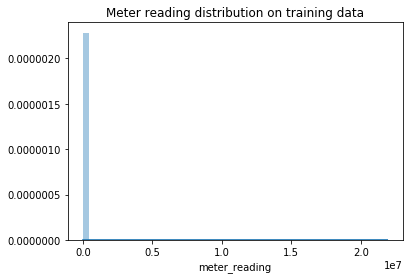

In [22]:
ax = sns.distplot(raw_train['meter_reading'])
ax.set_title('Meter reading distribution on training data')
raw_train['meter_reading'] = np.log1p(raw_train['meter_reading'])

In [23]:
# Remove outliers
# the below portion is from https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08
raw_train = raw_train [ raw_train['building_id'] != 1099 ]
raw_train = raw_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [24]:
raw_train['timestamp'] = pd.to_datetime(raw_train['timestamp'])
raw_train['is_holiday'] = (raw_train['timestamp'].dt.date.isin(us_holidays)).astype(np.int8)

In [25]:
building_traindata = pd.merge(raw_train,building_metadata,left_on = "building_id", right_on = "building_id", how = "left")
raw_train_data = pd.merge(building_traindata,weather_train,left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"])
na_columns = raw_train_data.isna().sum()
print(na_columns/raw_train_data.shape[0])

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
is_holiday            0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.612065
floor_count           0.823081
air_temperature       0.000297
cloud_coverage        0.433364
dew_temperature       0.000473
precip_depth_1_hr     0.185089
sea_level_pressure    0.057366
wind_direction        0.000000
wind_speed            0.000000
offset                0.000000
dtype: float64


In [26]:
raw_train_data['dayofweek'] = raw_train_data['timestamp'].dt.dayofweek.astype(np.uint8)
raw_train_data['weekday'] = raw_train_data['timestamp'].dt.weekday.astype(np.uint8)
raw_train_data['hour'] = raw_train_data['timestamp'].dt.hour.astype(np.uint8)
raw_train_data['day'] = raw_train_data['timestamp'].dt.day.astype(np.uint8)
raw_train_data['month'] = raw_train_data['timestamp'].dt.month.astype(np.uint8)

Text(0.5, 1.0, 'By meter average reading')

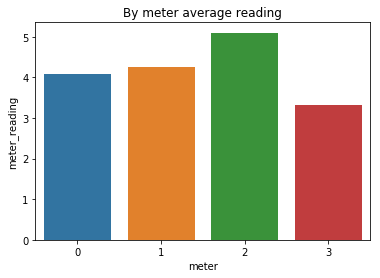

In [27]:
ax = sns.barplot(x="meter", y="meter_reading", data=raw_train_data.groupby('meter').mean().reset_index()[['meter','meter_reading']])
ax.set_title('By meter average reading')      

Text(0.5, 1.0, 'By meter count')

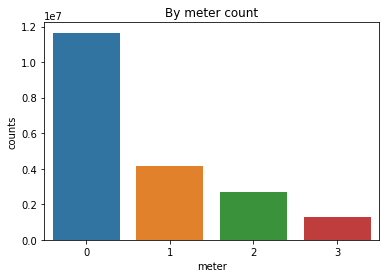

In [28]:
ax = sns.barplot(x="meter", y="counts", data=raw_train_data.groupby('meter').size().reset_index(name='counts'))
ax.set_title('By meter count')      

In [29]:
beaufort_vals = [(0,0,0.4),(1,0.5,1.5),(2,1.6,3.3),(3,3.4,5.5),(4,5.6,7.9),(5,8.0,10.7),(6,10.8,13.8),(7,13.9,17.1),
                 (8,17.2,20.7),(9,20.8,24.4),(10,24.5,28.4),(11,28.5,32.6),(12,32.7,400)]

In [30]:
def degToCompass(num):
    val=int((num/22.5)+.5)
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

In [31]:
raw_train_data['wind_direction'] = raw_train_data['wind_direction'].apply(degToCompass)

In [32]:
for i_scale in beaufort_vals:
    raw_train_data.loc[(raw_train_data['wind_speed']>=i_scale[1]) & (raw_train_data['wind_speed']<=i_scale[2]),'beaufort_scale'] = i_scale[0]

In [33]:
categoricalCols = ["site_id", "building_id", "primary_use", "hour", "weekday", "meter",  "wind_direction","is_holiday"]
numericCols = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature", 'precip_depth_1_hr', 'floor_count','beaufort_scale']

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(raw_train_data['primary_use'])
raw_train_data['primary_use'] = le.transform(raw_train_data['primary_use'])      

In [35]:
#featuresToUse = categoricalCols+numericCols
featuresToUse = numericCols+categoricalCols
train_data = raw_train_data.loc[:,featuresToUse]
train_data['square_feet'] = np.log(train_data['square_feet'])
train_data['year_built'] = train_data['year_built']-1900
train_data = reduce_mem_usage(train_data)
target_data = raw_train_data['meter_reading']

Memory usage of dataframe is 2165.92 MB
Memory usage after optimization is: 1035.88 MB
Decreased by 52.2%


In [36]:
del weather_train,raw_train_data
gc.collect()

12826

In [37]:
from sklearn.model_selection import StratifiedKFold,GroupKFold, KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

n_folds=2
cv = KFold(n_splits=n_folds, random_state=666, shuffle=False)

def computeRMSE(clf,index):
    y_predict = clf.predict(train_data.iloc[index])
    y_predict[y_predict<0]=0
    return np.sqrt(mean_squared_error( target_data.iloc[index], y_predict ))

In [38]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.4,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'max_bin':64,
            'early_stopping_rounds':200
            }

In [39]:
scores_lgb = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = train_data.columns     
models = []

for (train, val), i in zip(cv.split(train_data, train_data['building_id']), range(n_folds)):
    lgb_train = lgbm.Dataset(train_data.iloc[train,:], target_data.iloc[train],categorical_feature=categoricalCols)
    lgb_val = lgbm.Dataset(train_data.iloc[val,:], target_data.iloc[val],categorical_feature=categoricalCols)
    lgb_best = lgbm.train(
            params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=(lgb_train, lgb_val),
            verbose_eval = 100
            )    
    #feature_importances['fold_{}'.format(i + 1)] = lgb_best.feature_importances_
    feature_importances['fold_{}'.format(i + 1)] = lgb_best.feature_importance()
    rmse_train = computeRMSE(lgb_best,train)
    rmse_val = computeRMSE(lgb_best,val)
    scores_lgb.append((rmse_train, rmse_val))
    models.append(lgb_best)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.901358	valid_1's rmse: 1.17147
[200]	training's rmse: 0.854864	valid_1's rmse: 1.16809
[300]	training's rmse: 0.831117	valid_1's rmse: 1.16546
[400]	training's rmse: 0.812728	valid_1's rmse: 1.16487
[500]	training's rmse: 0.802913	valid_1's rmse: 1.16534
Early stopping, best iteration is:
[315]	training's rmse: 0.82739	valid_1's rmse: 1.16383


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.882695	valid_1's rmse: 1.16669
[200]	training's rmse: 0.82943	valid_1's rmse: 1.162
[300]	training's rmse: 0.806549	valid_1's rmse: 1.15861
[400]	training's rmse: 0.793368	valid_1's rmse: 1.15806
[500]	training's rmse: 0.780544	valid_1's rmse: 1.1626
Early stopping, best iteration is:
[359]	training's rmse: 0.799234	valid_1's rmse: 1.15715


In [40]:
print(scores_lgb)

[(0.8259711966669071, 1.162110898953808), (0.7972029031070108, 1.152687269923283)]


In [41]:
del train_data, target_data

In [42]:
del lgb_train,lgb_val,train, val

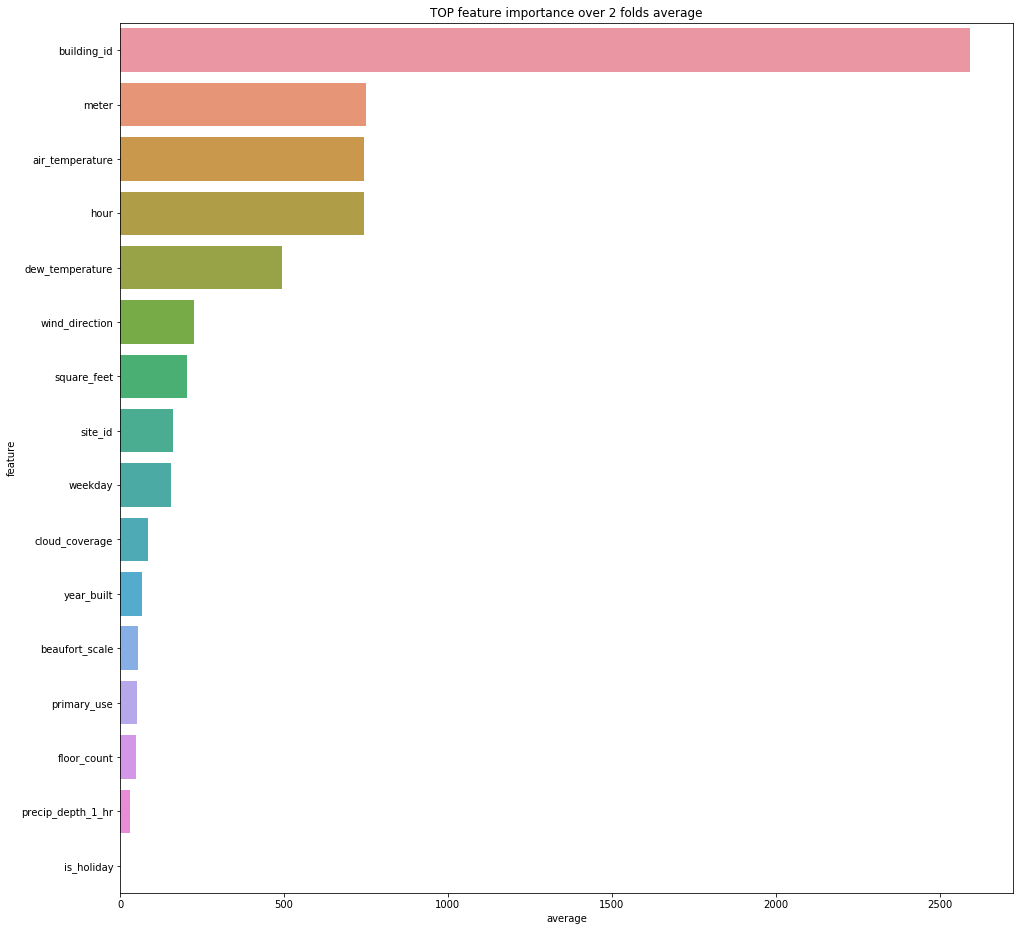

In [43]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(cv.n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title('TOP feature importance over {} folds average'.format(cv.n_splits));

In [44]:
raw_test = pd.read_csv(basePath+'test.csv')
raw_test['timestamp'] = pd.to_datetime(raw_test['timestamp'])
raw_test['is_holiday'] = (raw_test['timestamp'].dt.date.isin(us_holidays)).astype(np.int8)
building_testdata = pd.merge(raw_test,building_metadata,left_on = ["building_id"], right_on = ["building_id"],how='left')

In [45]:
del building_metadata,raw_test
gc.collect()
building_testdata = reduce_mem_usage(building_testdata)

Memory usage of dataframe is 3221.04 MB
Memory usage after optimization is: 1511.11 MB
Decreased by 53.1%


In [46]:
weather_test = pd.read_csv(basePath+'weather_test.csv')
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])
weather_test = alignTimestamp(weather_test)
for i,i_col in enumerate(weather_na_cols):
    weather_test[i_col].fillna(weather_test[i_col].mean(),inplace=True)
raw_test_data = pd.merge(building_testdata,weather_test,left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"],how = 'left')
del weather_test,building_testdata
gc.collect()

0

In [47]:
na_columns = raw_test_data.isna().sum()
print(na_columns/raw_test_data.shape[0])
for i,i_col in enumerate(weather_na_cols):
    raw_test_data[i_col].fillna(raw_test_data[i_col].mean(),inplace=True)

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
is_holiday            0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.589916
floor_count           0.826050
air_temperature       0.005649
cloud_coverage        0.468801
dew_temperature       0.006582
precip_depth_1_hr     0.187387
sea_level_pressure    0.060686
wind_direction        0.005101
wind_speed            0.005101
offset                0.005101
dtype: float64


In [48]:
raw_test_data['wind_direction'] = raw_test_data['wind_direction'].apply(degToCompass)
for i_scale in beaufort_vals:
    raw_test_data.loc[(raw_test_data['wind_speed']>=i_scale[1]) & (raw_test_data['wind_speed']<=i_scale[2]),'beaufort_scale'] = i_scale[0]

In [49]:
raw_test_data['primary_use'] = le.transform(raw_test_data['primary_use'])  
raw_test_data = reduce_mem_usage(raw_test_data)

Memory usage of dataframe is 4652.61 MB
Memory usage after optimization is: 2823.38 MB
Decreased by 39.3%


In [50]:
raw_test_data['dayofweek'] = raw_test_data['timestamp'].dt.dayofweek.astype(np.uint8)
raw_test_data['weekday'] = raw_test_data['timestamp'].dt.weekday.astype(np.uint8)
raw_test_data['hour'] = raw_test_data['timestamp'].dt.hour.astype(np.uint8)
raw_test_data['day'] = raw_test_data['timestamp'].dt.day.astype(np.uint8)
raw_test_data['month'] = raw_test_data['timestamp'].dt.month.astype(np.uint8)
raw_test_data = raw_test_data.drop(['timestamp'],axis=1)

In [51]:
raw_test_data['square_feet'] = np.log(raw_test_data['square_feet'])
raw_test_data['year_built'] = raw_test_data['year_built']-1900
raw_test_data = raw_test_data[featuresToUse]
raw_test_data,NAList = reduce_mem_usage(raw_test_data) 
gc.collect()

Memory usage of dataframe is 2107.59 MB
Memory usage after optimization is: 2187.13 MB
Decreased by -3.8%


ValueError: too many values to unpack (expected 2)

In [52]:
from tqdm import tqdm
i = 0
stepSize = 50000
predictions = []
for j in tqdm(range(int(np.ceil(raw_test_data.shape[0]/stepSize)))):
    predictions.append(np.expm1(sum([model.predict(raw_test_data.iloc[i:i+stepSize]) for model in models])/n_folds))
    i+=stepSize
predictions = np.concatenate(predictions)

100%|██████████| 834/834 [10:31<00:00,  1.32it/s]


In [53]:
submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = predictions
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission.csv', index=False)
submission

,row_id,meter_reading
0,0,160.798546
1,1,84.381680
2,2,17.309627
3,3,183.655373
4,4,722.747774
...,...,...
41697595,41697595,5.596535
41697596,41697596,4.206138
41697597,41697597,2.466844
41697598,41697598,172.952496


In [54]:
submission.describe()

,row_id,meter_reading
count,4.169760e+07,4.169760e+07
mean,2.084880e+07,3.701463e+02
std,1.203706e+07,1.878224e+03
min,0.000000e+00,0.000000e+00
25%,1.042440e+07,2.028274e+01
50%,2.084880e+07,7.322576e+01
75%,3.127320e+07,2.258583e+02
max,4.169760e+07,1.957396e+05


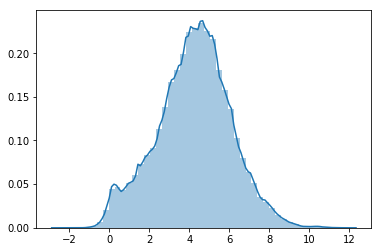

In [55]:
sns.distplot(np.log1p(predictions))